In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train_data.csv")
df

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375729,375729,1.0,0.866667,8/27/16,312.05,23.13,27.20,20.25,24.43,18.35,...,-15.64,-75.68,-3.09,6.93,-16.69,16.98,-13.85,50.25,-31.33,0.77
375730,375730,1.0,0.866667,8/28/16,305.82,23.13,27.20,20.25,24.43,18.35,...,-7.59,-76.42,-13.55,13.36,-15.96,20.45,-16.36,51.65,-30.73,10.10
375731,375731,1.0,0.866667,8/29/16,311.62,23.13,27.20,20.25,24.43,18.35,...,-6.25,-70.65,-23.93,22.62,-16.71,20.28,-15.48,48.58,-18.74,9.28
375732,375732,1.0,0.866667,8/30/16,304.54,23.13,27.20,20.25,24.43,18.35,...,-7.16,-57.67,-33.55,32.06,-16.07,16.60,-20.61,39.23,-16.26,-0.22


In [3]:
df['geometry'] = df.apply(lambda x: Point(x.lon, x.lat), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = {'init': 'epsg:4326'}
unique_lons = gdf['lon'].unique()
print(len(gdf['lon'].unique()))
unique_lats = gdf['lat'].unique()
print(len(gdf['lat'].unique()))
print("Available data per lat point")
lats = []
for ulat in unique_lats:
    lats.append(len(gdf[gdf['lat']==ulat]))
print(lats)
    
print("Available data per lon point")
lons=[]
for ulon in unique_lons:
    lons.append(len(gdf[gdf['lon']==ulon]))
print(lons)

print("Not every lon is combined with every lat")
points = []
for g in gdf["geometry"]:
    points.append((g.x,g.y))
print("Number of unique points")
print(len(set(points)))
print("Number if would be if every lon was combined with every lat")
print(31*23)

c:\Users\ninao\OneDrive - Danmarks Tekniske Universitet\WIDS2023\widsdatathon2023\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


31
23
Available data per lat point
[1462, 2193, 3655, 8041, 8772, 13889, 16813, 17544, 19006, 19737, 20468, 20468, 21199, 21199, 21199, 20468, 20468, 20468, 20468, 19737, 20468, 19737, 18275]
Available data per lon point
[16813, 16813, 14620, 15351, 9503, 14620, 14620, 14620, 14620, 7310, 1462, 13889, 13158, 13158, 13158, 13158, 13158, 13158, 13158, 13158, 12427, 12427, 12427, 12427, 11696, 10965, 10965, 10234, 9503, 7310, 5848]
Not every lon is combined with every lat
Number of unique points
514
Number if would be if every lon was combined with every lat
713


It is not the same data for every time step! The number of data for the different datapoints differs. 

In [4]:
# grouping the data into the dates - maybe not necessary?
time_series = gdf.groupby('startdate',group_keys=True).apply(lambda x: x)

In [13]:
# get the values that are interesting for the model
req_values = list(set(df.columns) - set(['lat','lon','index','startdate', 'contest-tmp2m-14d__tmp2m']))
y = df['contest-tmp2m-14d__tmp2m']
X = df[req_values]

In [5]:
# convert the date to datetime for torch to understand it
df['date'] = pd.to_datetime(gdf['startdate'], format='%m/%d/%y')

### Generate plots of pivot tables

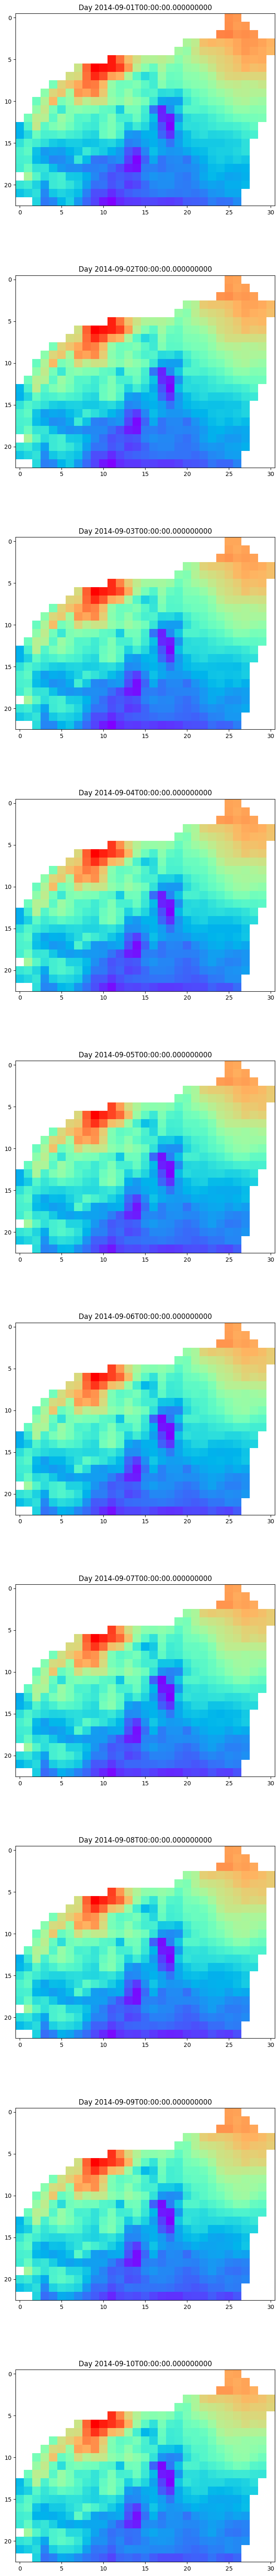

In [14]:
# Create a pivot table for each day
pivot_tables = {day: df[df['date']==day].pivot_table(
                     index='lat', 
                     columns='lon', 
                     values='contest-tmp2m-14d__tmp2m') for day in df['date'].unique()[:10]}

# pivot_plot = pivot_tables[:10]
# Create a grid of subplots
fig, axes = plt.subplots(nrows=len(pivot_tables), ncols=1, figsize=(8, 8*len(pivot_tables)))

# Plot the heatmap for each day in a different subplot
for i, (day, pivot_table) in enumerate(pivot_tables.items()):
    axes[i].imshow(pivot_table, cmap='rainbow')
    axes[i].set_title(f'Day {day}')

plt.show()

### Save the timeseries in a movie (very cool!)

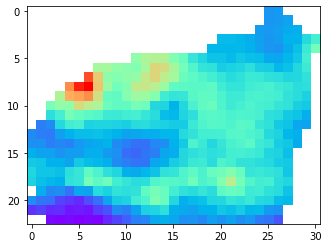

In [190]:
import matplotlib.cm as cm
import matplotlib.animation as animation

frames = [] # for storing the generated images
fig = plt.figure()
for i, (day, pivot_table) in enumerate(pivot_tables.items()):
    frames.append([plt.imshow(pivot_table, cmap='rainbow')])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
plt.show()

### Fill the missing values with -1 and create a mask that can also be passed to the model

In [191]:
# check that all values are larger than 0
print(min(df['contest-pevpr-sfc-gauss-14d__pevpr']) > 0)

True


In [192]:
for date in pivot_tables:
    pivot_tables[date] = pivot_tables[date].fillna(-1)

In [196]:
# stack the pivot tables together and unravel
df_result = pd.concat(pivot_tables)
df_result['date'] = df_result.index.get_level_values(0)
df_result = df_result.stack().reset_index()

# set the columns of the dataset back to what they where (this time containing more lat/lon values)
columns = {'level_1':'lat', 'level_2':'lon', 0:'contest-pevpr-sfc-gauss-14d__pevpr'}
#other_columns = {i:j for j,i in zip(req_values, range(len(req_values)))}
#columns.update(other_columns)
df_result.rename(columns=columns, 
                 inplace=True)
df_result.rename(columns={'level_0':'date', 'level_1':'lat', 'level_2':'lon'}, inplace=True)
df_result.drop(df_result[df_result.lon == 'date'].index, inplace=True)
df_result.reset_index(drop=True, inplace=True)
print(df_result)

            date  lat       lon contest-pevpr-sfc-gauss-14d__pevpr
0     2022-11-01  0.0       0.0                               -1.0
1     2022-11-01  0.0  0.033333                               -1.0
2     2022-11-01  0.0  0.066667                               -1.0
3     2022-11-01  0.0       0.1                               -1.0
4     2022-11-01  0.0  0.133333                               -1.0
...          ...  ...       ...                                ...
43488 2022-12-31  1.0  0.866667                              86.17
43489 2022-12-31  1.0       0.9                               -1.0
43490 2022-12-31  1.0  0.933333                               -1.0
43491 2022-12-31  1.0  0.966667                               -1.0
43492 2022-12-31  1.0       1.0                               -1.0

[43493 rows x 4 columns]


In [206]:
# remove the target column from the original dataset
df_temp = df.drop(['contest-pevpr-sfc-gauss-14d__pevpr','index','startdate'], axis=1)

# merge the original df with this new df on the lat and lon values 
new_df = pd.merge(df_result, df_temp,  how='left', left_on=['lat','lon','date'], right_on = ['lat','lon','date'])

# fill all nan values with -1
new_df = new_df.fillna(-1)
new_df

,date,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,2022-11-01,0.0,0.000000,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
1,2022-11-01,0.0,0.033333,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
2,2022-11-01,0.0,0.066667,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
3,2022-11-01,0.0,0.100000,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
4,2022-11-01,0.0,0.133333,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43488,2022-12-31,1.0,0.866667,86.17,4.6,8.71,6.05,10.08,6.39,8.42,...,116.77,25.33,26.17,30.68,-3.24,27.7,-28.75,0.15,16.64,19.27
43489,2022-12-31,1.0,0.900000,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
43490,2022-12-31,1.0,0.933333,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00
43491,2022-12-31,1.0,0.966667,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00


In [ ]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

#drop startdate and date columns
df = df.drop(columns=['date','startdate'])

# Data preprocessing

In [4]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
# get the values that are interesting for the model
min_df = df[['lat','lon','index','startdate', 'contest-tmp2m-14d__tmp2m']]

min_df.startdate = pd.to_datetime(min_df.startdate)
min_df['year'] = min_df['startdate'].dt.year
min_df['date'] = min_df['startdate'].dt.date
min_df['day'] = min_df['startdate'].dt.day
min_df

C:\Users\ninao\AppData\Local\Temp\ipykernel_19524\1813723051.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_df.startdate = pd.to_datetime(min_df.startdate)
C:\Users\ninao\AppData\Local\Temp\ipykernel_19524\1813723051.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_df['year'] = min_df['startdate'].dt.year
C:\Users\ninao\AppData\Local\Temp\ipykernel_19524\1813723051.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,lat,lon,index,startdate,contest-tmp2m-14d__tmp2m,year,date,day
0,0.0,0.833333,0,2014-09-01,28.744480,2014,2014-09-01,1
1,0.0,0.833333,1,2014-09-02,28.370585,2014,2014-09-02,2
2,0.0,0.833333,2,2014-09-03,28.133059,2014,2014-09-03,3
3,0.0,0.833333,3,2014-09-04,28.256798,2014,2014-09-04,4
4,0.0,0.833333,4,2014-09-05,28.372353,2014,2014-09-05,5
...,...,...,...,...,...,...,...,...
375729,1.0,0.866667,375729,2016-08-27,17.150954,2016,2016-08-27,27
375730,1.0,0.866667,375730,2016-08-28,16.962051,2016,2016-08-28,28
375731,1.0,0.866667,375731,2016-08-29,16.915474,2016,2016-08-29,29
375732,1.0,0.866667,375732,2016-08-30,16.536761,2016,2016-08-30,30


In [5]:
scaler = MinMaxScaler()
y = scaler.fit_transform(min_df[['contest-tmp2m-14d__tmp2m']])

In [6]:
min_df['target'] = y
min_df = min_df.drop(['contest-tmp2m-14d__tmp2m', 'startdate', 'date'], axis = 1)
print(min_df)

        lat       lon   index  year  day    target
0       0.0  0.833333       0  2014    1  0.852524
1       0.0  0.833333       1  2014    2  0.846032
2       0.0  0.833333       2  2014    3  0.841908
3       0.0  0.833333       3  2014    4  0.844057
4       0.0  0.833333       4  2014    5  0.846063
...     ...       ...     ...   ...  ...       ...
375729  1.0  0.866667  375729  2016   27  0.651239
375730  1.0  0.866667  375730  2016   28  0.647960
375731  1.0  0.866667  375731  2016   29  0.647151
375732  1.0  0.866667  375732  2016   30  0.640576
375733  1.0  0.866667  375733  2016   31  0.629711

[375734 rows x 6 columns]


C:\Users\ninao\AppData\Local\Temp\ipykernel_19524\3498717376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_df['target'] = y


In [7]:
X = torch.tensor(min_df.values)[:2000]
y = torch.tensor(y)[:2000]

X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):].double()
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):].double()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_realtrain = X_train[:-14,:].double()
y_realtrain = y_train[14:,:].double()

torch.Size([1600, 6])
torch.Size([400, 6])
torch.Size([1600, 1])
torch.Size([400, 1])


In [8]:
# a basic rnn model that predicts always the next 14 days based on X and with output y

class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        
        return output


input_size = 6
hidden_dim = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.01

model = RNN(input_size, hidden_dim, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

RNN(
  (rnn): RNN(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
for param in model.parameters():
    param.data = param.data.double()

# train the model
for epoch in range(num_epochs):
    hidden = None  
    outputs = model(X_realtrain, hidden)
    optimizer.zero_grad()
    loss = criterion(outputs, y_realtrain)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 16.1142
Epoch [20/100], Loss: 0.9125
Epoch [30/100], Loss: 0.2029
Epoch [40/100], Loss: 0.1234
Epoch [50/100], Loss: 0.1074
Epoch [60/100], Loss: 0.0531
Epoch [70/100], Loss: 0.0358
Epoch [80/100], Loss: 0.0280
Epoch [90/100], Loss: 0.0226
Epoch [100/100], Loss: 0.0193


Test loss: 0.06740


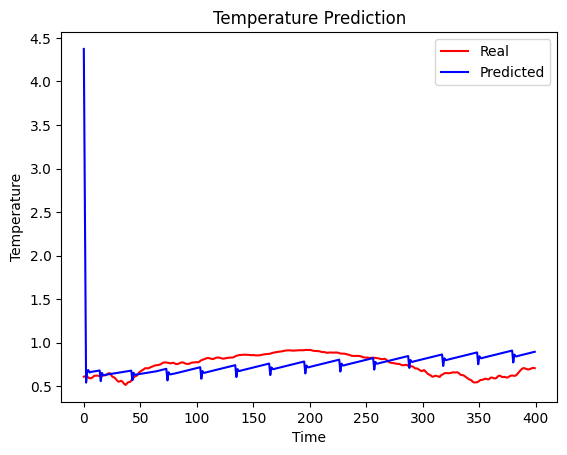

In [11]:
model.eval()
with torch.no_grad():
    hidden = None 
    y_pred = model(X_test, hidden)
    loss = criterion(y_pred, y_test)
    print(f'Test loss: {loss.item():.5f}')

y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()

plt.plot(y_test, color='red', label='Real')
plt.plot(y_pred, color='blue', label='Predicted')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# save the model
torch.save(model, 'model.pt')

# Benchmark model - simple RNN implementation as shown on 
https://medium.com/iet-vit/lets-build-a-rnn-pytorch-style-c960207f1fb3

In [16]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
seq_length = 20
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) 
#size becomes (seq_length+1, 1), adds an input_size dimension

In [18]:
x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [20]:
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [22]:
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        # Representing Memory #
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.47255533933639526


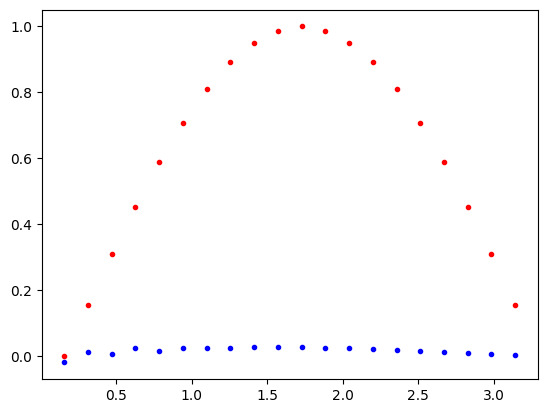

Loss:  0.010770397260785103


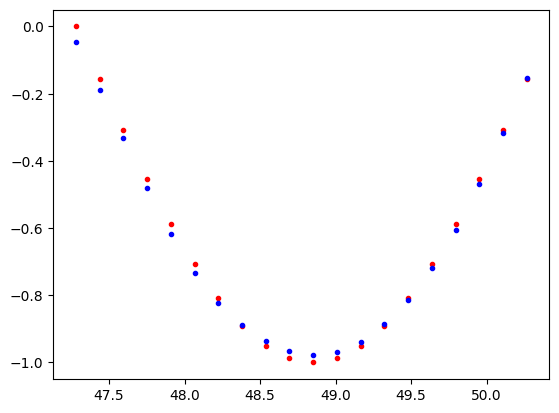

Loss:  0.00040917223668657243


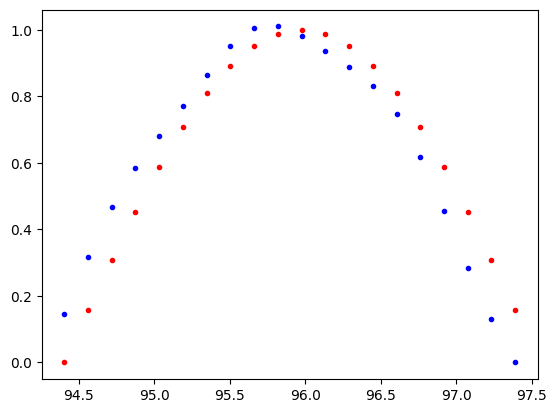

Loss:  0.0037306298036128283


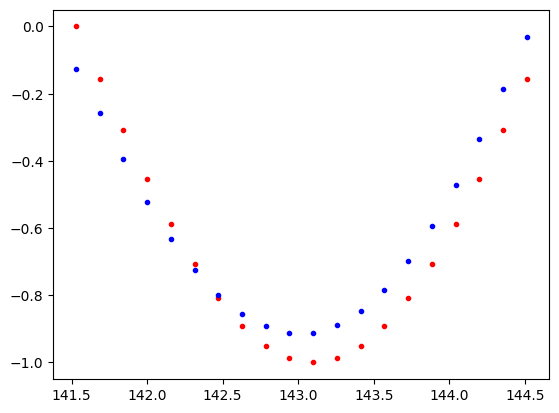

Loss:  0.0013662336859852076


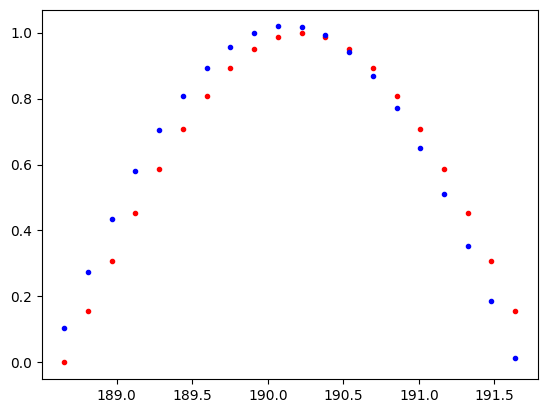

In [23]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)



## Example Code and learning torch a bit better

In [126]:
df_test = pd.DataFrame({'lat': [1, 2, 3, 4, 5, 1,2,4,5, 1, 2, 3, 4, 5, 1,2,4,5], 
                   'lon': [6, 6,6,6,6,7,7,7,7,6, 6,6,6,6,7,7,7,7], 
                   'date': ['01-01-23','01-01-23','01-01-23','01-01-23','01-01-23','01-01-23','01-01-23','01-01-23','01-01-23',
                            '02-01-23','02-01-23','02-01-23','02-01-23','02-01-23','02-01-23','02-01-23','02-01-23','02-01-23'], 
                   'value':[2,3,4,2,3,1,2,3,2,2,3,4,2,3,1,2,3,2]})
# 1. transform the date to datetime
df_test['date'] = pd.to_datetime(df_test['date'], format='%d-%m-%y')
# 2. extract time information
df_test['hour'] = df_test['date'].dt.hour
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['day'] = df_test['date'].dt.day
df_test['dayofweek'] = df_test['date'].dt.dayofweek

# 3. normalize data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

#scaler = MinMaxScaler()
#df_test[['lat', 'lon', 'value']] = scaler.fit_transform(df_test[['lat', 'lon', 'value']])

# 4. define target value
X = df_test.drop(columns=['value','date'])
y = df_test['value']

{1: lon    6    7
lat          
1    2.0  1.0
2    3.0  2.0
3    4.0  NaN
4    2.0  3.0
5    3.0  2.0, 2: lon    6    7
lat          
1    2.0  1.0
2    3.0  2.0
3    4.0  NaN
4    2.0  3.0
5    3.0  2.0}


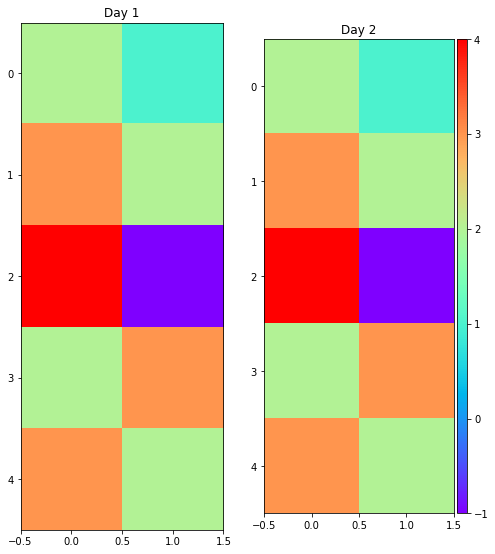

In [163]:
# Create a pivot table for each day
pivot_tables = {day: df_test[df_test['day']==day].pivot_table(index='lat', columns='lon', values='value') for day in df_test['day'].unique()}
print(pivot_tables)
for day in pivot_tables:
    pivot_tables[day] = pivot_tables[day].fillna(-1)


# Create a grid of subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(nrows=1, ncols=len(pivot_tables), figsize=(8, 8*len(pivot_tables)))
for i, (day, pivot_table) in enumerate(pivot_tables.items()):
    im = axes[i].imshow(pivot_table, cmap='rainbow')
    axes[i].set_title(f'Day {day}')
    divider = make_axes_locatable(axes[i])
    cbar.set_label('Value')
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
plt.show()

In [164]:
df_result = pd.concat(pivot_tables)
df_result['day'] = df_result.index.get_level_values(0)
df_result = df_result.stack().reset_index()
df_result.rename(columns={'level_1':'lat', 'level_2':'lon', 0:'value'}, inplace=True)
df_result.rename(columns={'level_0':'day', 'level_1':'lat', 'level_2':'lon'}, inplace=True)
df_result.drop(df_result[df_result.lon == 'day'].index, inplace=True)
df_result.reset_index(drop=True, inplace=True)
print(df_result)

    day  lat lon  value
0     1    1   6    2.0
1     1    1   7    1.0
2     1    2   6    3.0
3     1    2   7    2.0
4     1    3   6    4.0
5     1    3   7   -1.0
6     1    4   6    2.0
7     1    4   7    3.0
8     1    5   6    3.0
9     1    5   7    2.0
10    2    1   6    2.0
11    2    1   7    1.0
12    2    2   6    3.0
13    2    2   7    2.0
14    2    3   6    4.0
15    2    3   7   -1.0
16    2    4   6    2.0
17    2    4   7    3.0
18    2    5   6    3.0
19    2    5   7    2.0


In [118]:
df_test_series = df_test.groupby('date',group_keys=True).apply(lambda x: x)
#print(df_test_series)

#plt.imshow(df_test_series.pivot_table(index='lat', columns='lon', values='value'), cmap='rainbow')
#plt.colorbar()
#plt.show()

In [ ]:
# 5. reshape data
X = np.array(X)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

# 6. convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

In [133]:
from scipy.interpolate import griddata

# Create a grid of the latitude and longitude values
pivot_tables = {day: df_test[df_test['day']==day].pivot_table(index='lat', columns='lon', values='value') for day in df_test['day'].unique()}
grid_x, grid_y = [np.mgrid[df_test[df_test['day']==day]['lon'].min():df_test[df_test['day']==day]['lon'].max():5j, df_test[df_test['day']==day]['lat'].min():df_test[df_test['day']==day]['lat'].max():2j] for day in df_test['day'].unique()]
print(grid_y)
# Interpolate the data to the grid
grid_z = griddata(df_test[['lon', 'lat']], df_test['value'], (grid_x, grid_y), method='cubic')

[[[6.   6.  ]
  [6.25 6.25]
  [6.5  6.5 ]
  [6.75 6.75]
  [7.   7.  ]]

 [[1.   5.  ]
  [1.   5.  ]
  [1.   5.  ]
  [1.   5.  ]
  [1.   5.  ]]]


In [129]:
print(grid_z)

[[2.         3.        ]
 [1.75921886 2.85072597]
 [1.51053584 2.61511539]
 [1.2565849  2.32194712]
 [1.         2.        ]]


## Simple implementation of Convolutional LSTM model in Pytorch

In [224]:
import torch
import torch.nn as nn

class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, kernel_size, stride, padding):
        super(ConvLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.conv = nn.Conv2d(input_size, hidden_size, kernel_size, stride, padding)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        # Pass the input through the convolutional layer
        conv_out = self.conv(input)
        # Pass the convolutional output through the LSTM layer
        lstm_out, hidden = self.lstm(conv_out, hidden)

        return lstm_out, cell

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Instantiate the model
convlstm = ConvLSTM(input_size=3, hidden_size=32, num_layers=2, kernel_size=3, stride=1, padding=1)

# Define the input and hidden states
input = torch.randn(10, 3, 256, 256) # Example input size
hidden = convlstm.init_hidden(batch_size=10)
cell = convlstm.init_hidden(batch_size=10)

# Pass the input through the model
output, hidden = convlstm(input, hidden)

RuntimeError: input must have 3 dimensions, got 4

## Another example using a masking layer
The masking layer can be used to tell the model to ignore all values that are -1 of the input data. This is super handy for my case!! In this example, the masking layer is set to ignore any input values equal to -1, which you can use to represent missing data in your dataset.

You can then create a masking tensor of the same shape as the input data, with -1 in the positions where there is no data and 0 in the positions where there is data.

You can then use this tensor as an input to the masking layer, and the layer will ignore the corresponding input values during training and inference.

In [220]:
import torch
import torch.nn as nn

batch_size = 10
time_steps = 10
lat = 10
lon = 10

class MaskingLayer(nn.Module):
    def __init__(self, mask):
        super(MaskingLayer, self).__init__()
        self.register_buffer('mask', mask)

    def forward(self, x):
        return x * self.mask

class SpatiotemporalModel(nn.Module):
    def __init__(self):
        super(SpatiotemporalModel, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.lstm_layer = nn.LSTM(input_size=32, hidden_size=32, num_layers=1, batch_first=True)
        self.fc_layer = nn.Linear(in_features=32, out_features=1)

    def forward(self, x, masking_layer):
        # Use the mask to filter the data before passing it through the LSTM layer
        x = masking_layer(x)
        #x = x.reshape(batch_size, -1, 32)
        # Pass the data through the convolutional layer
        x = self.conv_layer(x)
        x, _ = self.lstm_layer(x)
        # Pass the data through the fully connected layer
        x = self.fc_layer(x)
        return x

# Create the model
model = SpatiotemporalModel()

# Sample input data and mask
data = torch.randn(batch_size, time_steps, lat, lon)
mask = torch.zeros(batch_size, time_steps, lat, lon)
mask[data != -1] = 1

# Create the masking layer
masking_layer = MaskingLayer(mask)

# Pass the data and mask through the model
output = model(data, masking_layer)

RuntimeError: input must have 3 dimensions, got 4